# Loan Predictions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Data Source: https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

[Dream Housing Finance](https://dreamhomefinancing.com) company provides mortgage lending solutions to home buyers. Using this partial dataset they provided, the company wants to automate the loan eligibility process (in real-time) based on customer information provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. 

In [1]:
%load_ext watermark
%watermark -a 'Vusal Babashov' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

Author: Vusal Babashov

Last updated: 2021-04-22

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 7.22.0

numpy     : 1.19.2
mlxtend   : 0.18.0
matplotlib: 3.3.4
sklearn   : 0.24.1



In [2]:
#import your libraries
import pandas as pd
import sklearn as sk
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



__author__ = "Vusal Babashov"
__email__ = "vbabashov@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [3]:
#load the data into a Pandas dataframe
data = pd.read_csv("/Users/vusalbabashov/Desktop/loan-classification/data/raw/loan_data_set.csv")

### ---- 3 Examine the data ----

In [4]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
#look for duplicate data
data.duplicated().sum()

0

In [6]:
# check if there is a missing value in each column and how many missing cells for the dataset
with pd.option_context('display.max_rows', None):
    display(data.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
# check the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### ---- 4 Explore the data (EDA) ----

In [8]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features
data.describe(include = [np.number])

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
data.describe(include = ['O'])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP002319,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [17]:
# Check the class imbalance
data.Loan_Status.value_counts()/data.shape[0]

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

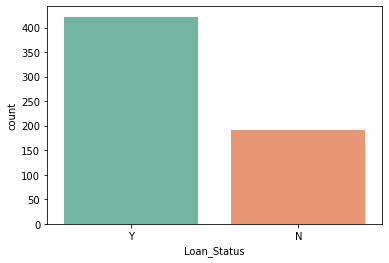

In [46]:
sns.countplot(x = "Loan_Status", data=data, palette = "Set2")

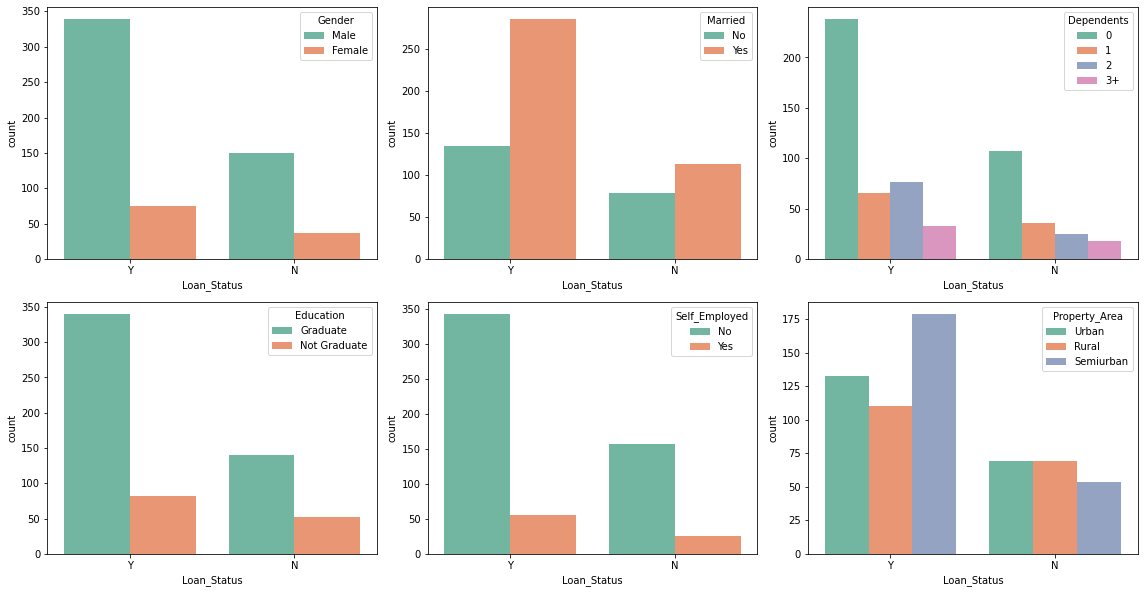

In [47]:
plt.figure (figsize= (16, 12))
for count, value in enumerate(data.select_dtypes(include='object').columns.drop(['Loan_ID', 'Loan_Status'])):
    plt.subplot(3, 3, count+1)
    sns.countplot(x = "Loan_Status", hue=value, data=data, palette = "Set2")
plt.tight_layout()
plt.show()

In [73]:
data["Loan_Status"].groupby(data["Gender"]).value_counts(normalize=True).reset_index(name='prop')

,Gender,Loan_Status,prop
0,Female,Y,0.669643
1,Female,N,0.330357
2,Male,Y,0.693252
3,Male,N,0.306748


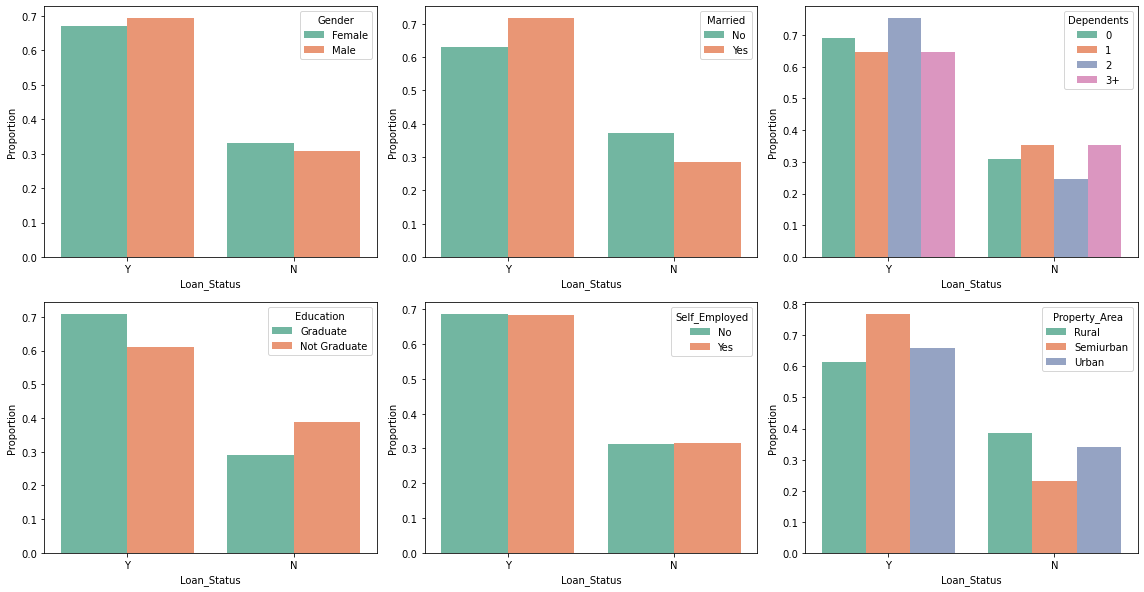

In [78]:
plt.figure (figsize= (16, 12))
for count, value in enumerate(data.select_dtypes(include='object').columns.drop(['Loan_ID', 'Loan_Status'])):
    plt.subplot(3, 3, count+1)
    sns.barplot(data = data["Loan_Status"].groupby(data[value]).value_counts(normalize=True).reset_index(name='Proportion') , 
                        x = 'Loan_Status', 
                        y = 'Proportion',
                        hue = value,
                        palette="Set2")
plt.tight_layout()
plt.show()

### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data